In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import time
import gc
import math

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install hdf5storage
import hdf5storage
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.fft import fft, fftfreq, fft2, rfft
from scipy.signal import iirnotch, freqz
from scipy.signal import spectrogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 7.7 MB/s eta 0:00:00


In [7]:
# Luca/Michael code
def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict


def automatic_bad_channel_detection(lfp, verbose=False):
    """
    Automatic Iterative Standard Deviation method (Komosar, et al. 2022)
    Input: lfp (channels x time x trials)
    Output: remaining_channels (i.e. "clean" channels)
    """
    remaining_channels = np.arange(lfp.shape[0])
    k = 0  # iteration counter
    sd_pk = np.inf  # std of all individual channel std's
    while sd_pk > 5:
        if verbose:
            print(sd_pk)
        if k > 0:
            remaining_channels = np.setdiff1d(remaining_channels, bad_channels_k)
        sd_k = np.median(
            np.std(lfp[remaining_channels, :, :], axis=1), axis=1
        )  # std of each channel (median across trials)
        m_k = np.median(sd_k)  # median of channel std's
        third_quartile = np.percentile(sd_k, 75)
        if sd_pk == np.std(sd_k):  # if no channels are removed (not in paper)
            break
        sd_pk = np.std(sd_k)
        bad_channels_k = []
        for ch in remaining_channels:
            sd_jk = np.std(lfp[ch, :, :])
            if sd_jk < 10e-4:
                bad_channels_k.append(ch)
            elif sd_jk > 100:
                bad_channels_k.append(ch)
            elif abs(sd_jk - m_k) > third_quartile:
                bad_channels_k.append(ch)
        k += 1
    return remaining_channels


def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=0)
    # Return the filtered LFP signal
    return lfp_filtered


def trajectory_plot_2d(mua, cond_names, data_type, save_dir):
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=2)
    pca.fit(mua_mean.T)
    ev = pca.explained_variance_ratio_
    X_new = pca.transform(mua_mean.T).T
    X_new = X_new.reshape((2, mua.shape[1], mua.shape[3]))
    # plot
    f = plt.figure()
    for c in range(mua.shape[3]):
        plt.plot(X_new[0, :, c], X_new[1, :, c], label=cond_names[c])
    plt.xlabel(f"PC 1 ({ev[0] * 100:.2f}%)")
    plt.ylabel(f"PC 2 ({ev[1] * 100:.2f}%)")
    plt.legend()
    # box off
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{data_type} Trajectories")
    plt.savefig(os.path.join(save_dir, data_type + "_pca.png"))
    plt.close(f)


def classify_trajectories(mua, import_conds, nw, nt_ac):
    npc = 2  # number of principal components
    # project onto first 2 PCs
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=npc)
    pca.fit(mua_mean.T)
    pc = pca.components_
    ev = pca.explained_variance_ratio_

    projected = np.empty((npc, nw, nt_ac, len(import_conds)))
    for t in range(nt_ac):
        X = mua[:, :, t, :].reshape((mua.shape[0], mua.shape[1] * mua.shape[3])).T
        X_new = np.matmul(X, pc.T)
        X_new = X_new.reshape((nw, len(import_conds), npc))
        projected[:, :, t, :] = X_new.transpose((2, 0, 1))

    X = projected.transpose((2, 3, 0, 1))
    X = X.reshape((nt_ac * len(import_conds), X.shape[2], X.shape[3]))
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    # y = np.repeat(np.arange(len(import_conds)), nt_ac)
    y = np.tile(np.arange(len(import_conds)), nt_ac)

    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    sss.get_n_splits(X, y)
    acc = []
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train = X[train_index, :]
        X_train = StandardScaler().fit_transform(X_train)
        X_test = X[test_index, :]
        X_test = StandardScaler().fit_transform(X_test)
        y_train = y[train_index]
        y_test = y[test_index]
        clf = LogisticRegression(max_iter=2000, random_state=0).fit(X_train, y_train)
        acc.append(clf.score(X_test, y_test))
    return acc


def box_plot(data, edge_color, fill_color):
    bp = plt.boxplot(data, patch_artist=True, showfliers=False)

    for element in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]:
        plt.setp(bp[element], color=edge_color)

    for patch in bp["boxes"]:
        patch.set(facecolor=fill_color)

    return bp


# Placeholder for any processing we might want to do while loading
def load_data(filename):
  '''We might need separate functions. It takes a long time to upload the
  .mat files to colab, so if Colab can just find the files stored on our
  computer that might be better. Or perhaps upload the files to Google drive'''
  raw, epoched, param_dict = import_mat(filename)
  return raw, epoched, param_dict


# Placeholder for any processing we might want to do while loading
def load_all_datasets(n_classes):
  # When loading all data, we must do it seperatly due to memory constraints
  raw1, _, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
  raw2, _, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
  raw = np.concatenate((raw1, raw2), axis=2)
  del raw1, raw2
  raw3, _, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
  raw = np.concatenate((raw, raw3), axis=2)
  del raw3
  raw4, _, _= import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
  raw = np.concatenate((raw, raw4), axis=2)
  del raw4
  raw5, _, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
  raw = np.concatenate((raw, raw5), axis=2)
  del raw5
  raw6, _, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
  raw = np.concatenate((raw, raw6), axis=2)
  del raw6
  raw7, _, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
  raw = np.concatenate((raw, raw7), axis=2)
  del raw7
  raw8, _, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')
  raw = np.concatenate((raw, raw8), axis=2)
  del raw8
  good_channels, bad_channel = std_bad_channels(raw)
  print("Bad Channel: ", bad_channel)
  del raw
  _, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
  _, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
  epoched_left = np.concatenate((epoched1, epoched2), axis=2)
  del epoched1, epoched2
  _, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
  epoched_left = np.concatenate((epoched_left, epoched3), axis=2)
  del epoched3
  _, epoched4, _= import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
  epoched_left = np.concatenate((epoched_left, epoched4), axis=2)
  del epoched4
  if n_classes == 10:
      y_left = np.repeat(np.arange(0, 5), int(epoched_left.shape[2]))
      print("Y_LEFt", y_left.shape)
      print("epoched_left", epoched_left.shape)
  _, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
  _, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
  epoched_right = np.concatenate((epoched5, epoched6), axis=2)
  del epoched6
  _, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
  epoched_right = np.concatenate((epoched_right, epoched7), axis=2)
  del epoched7
  _, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')
  epoched_right = np.concatenate((epoched_right, epoched8), axis=2)
  del epoched8
  epoched = np.concatenate((epoched_left, epoched_right), axis=2)
  print("EPOCHED SHAPE", epoched_right.shape)
  print("EPOCHED SHAPE", epoched_left.shape)
  if n_classes == 10:
      y_right = np.repeat(np.arange(5, 10), int(epoched_right.shape[2]))
      print("Y_Right", y_right.shape)
      print("epoched_right", epoched_right.shape)
      y_labels_10 = np.concatenate((y_left, y_right), axis = 0)
      print("y_labels", y_labels_10.shape)
      y_labels_5 = np.repeat(np.arange(0, 5), int(epoched.shape[2]))
      epoched = epoched[good_channels]
      return epoched, y_labels_5, y_labels_10

  else:
       y_labels = np.repeat(np.arange(0, 4), int(epoched.shape[2]))
  del epoched_left, epoched_right
  #del y_left, y_right
  epoched = epoched[good_channels]
  return epoched, y_labels, _

def std_bad_channels(lfp):
    # Automatic Iterative Standard Deviation method (Komosar, et al. 2022)
    # Adapted to Python by @madepass
    # Improved by @ManuelHernadezA
    # Arguments
    # =========
    # lfp: (n_channels, n timepoints, n_trials)
    all_channels = np.arange(lfp.shape[0])
    remaining_channels = all_channels.copy()
    k = 0  # iteration counter
    sd_pk = np.inf  # std of all individual channel std's
    std_all = np.std(lfp, axis=1)
    if len(std_all.shape) > 1:  # if lfp split into epochs (channels x time x trials)
        std_all = np.median(std_all, axis=1)
    while sd_pk > 5:
        sd_k = std_all[remaining_channels]  # std of each channel
        m_k = np.median(sd_k)  # median of channel std's
        third_quartile = np.percentile(sd_k, 75)
        temp = np.std(sd_k)
        if sd_pk == temp:  # if no channels are removed (not in paper)
            break
        sd_pk = temp
        bad_channels_k = []
        for ch in remaining_channels:
            sd_jk = std_all[ch]
            if sd_jk < 10e-1:
                bad_channels_k.append(ch)
            elif sd_jk > 100:
                bad_channels_k.append(ch)
            elif abs(sd_jk - m_k) > third_quartile:
                bad_channels_k.append(ch)
        remaining_channels = np.setdiff1d(remaining_channels, bad_channels_k)
        k += 1
    bad_channels = np.setdiff1d(all_channels, remaining_channels)
    return remaining_channels, bad_channels

# Find the avg of the previous values for all outlier values
def smooth_outliers(EEG, multiplier=2.0, prev_points=5, visualize=False, fs=2000):
    if visualize:
      EEG_original = EEG.copy()
    n_timepoints, n_channels = EEG.shape
    # We use the avg std to better remove outliers without impacting the data
    std_mean = np.mean(np.std(EEG, axis=0, keepdims=True))
    # Determine the threshold based on STD
    thresh = multiplier * std_mean
    for ch in range(n_channels):
        for t in range(n_timepoints):
          # For initial points, just clip
          if t < prev_points:
            EEG[t, ch] = np.clip(EEG[t, ch], -thresh, thresh)
            continue
          val = EEG[t, ch]
          # For outlier values, use the mean of previous values
          if np.abs(val) > thresh:
              replacement = np.mean(EEG[t - prev_points:t, ch])
              EEG[t, ch] = replacement
    # Helps us visualize the changes made, as well as the threshold
    if visualize:
        time = np.arange(n_timepoints) / fs
        for ch in range(n_channels):
            plt.figure(figsize=(10, 4))
            plt.plot(time, EEG_original[:, ch], label='Original', alpha=0.5, color='gray')
            plt.plot(time, EEG[:, ch], label='Cleaned', color='green')
            plt.axhline(thresh, linestyle='--', color='red', label='+2×STD')
            plt.axhline(thresh, linestyle='--', color='blue', label='−2×STD')
            plt.title(f"EEG Cleaning - Channel {ch}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()
    return EEG

def visualize_spectogram(Sxx, f, t, title = "Spectogram", normalize=True):
    # Normalize each frequency bin by its mean (or max) across time
    if normalize:
        Sxx_max = np.max(Sxx, axis=1, keepdims=True)
        Sxx_min = np.min(Sxx, axis=1, keepdims=True)
        Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
    plt.imshow(Sxx, aspect='auto', origin='lower',
              extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], num_yticks)
    plt.yticks(yticks, labels=np.round(yticks))

    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    plt.xticks(xticks, labels=np.round(xticks, 3), rotation=45)
    plt.show()

def visualize_spectogram_multiple(Sxx_list, f, t, normalize=True):
    # Create a plot with 5 subbplots, where each acts like visualize_spectogram
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))
    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], num_yticks)
    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    for i in range(len(Sxx_list)):
        Sxx = Sxx_list[i]
        if normalize:
            Sxx_max = np.max(Sxx, axis=1, keepdims=True)
            Sxx_min = np.min(Sxx, axis=1, keepdims=True)
            Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
        im = axs[int(i/2)][i%2].imshow(Sxx, aspect='auto', origin='lower',
                      extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')
        axs[int(i/2)][i%2].set_title(f'State {i+1}')
        axs[int(i/2)][i%2].set_xlabel('Time (s)')
        axs[int(i/2)][i%2].set_ylabel('Frequency (Hz)')
        axs[int(i/2)][i%2].set_xticks(xticks)
        axs[int(i/2)][i%2].set_yticks(yticks)
        fig.colorbar(im, ax=axs[int(i/2)][i%2])
    plt.tight_layout()
    plt.show()

def visualize_spectogram_difference(Sxx_list, f, t, normalize=True):
    # Normalize by both spectograms!
    for i in range(len(Sxx_list)):
        print("Difference of states compared to state", i)
        Sxx_diff = []
        # We take the state we want to compare with
        Sxx_base = Sxx_list[i]
        for j in range(len(Sxx_list)):
            # We take the state we want to compare to
            Sxx_temp = Sxx_list[j]
            if normalize:
                # We normalize it by the time axis
                Sxx_diff_temp_max = np.max(np.maximum(np.max(Sxx_temp, axis=1, keepdims=True), np.max(Sxx_base, axis=1, keepdims=True)), axis=1,  keepdims=True)
                Sxx_diff_temp_min = np.min(np.minimum(np.min(Sxx_temp, axis=1, keepdims=True), np.min(Sxx_base, axis=1, keepdims=True)), axis=1, keepdims=True)
                Sxx_temp = (Sxx_temp - Sxx_diff_temp_min) / (Sxx_diff_temp_max - Sxx_diff_temp_min)
                Sxx_base = (Sxx_base - Sxx_diff_temp_min) / (Sxx_diff_temp_max - Sxx_diff_temp_min)
            # We get the abs value (we care about the distance)
            Sxx_diff_temp = np.abs(Sxx_base - Sxx_temp)
            Sxx_diff.append(Sxx_diff_temp)

        visualize_spectogram_multiple(Sxx_diff, f, t, normalize=True)


def clean_spectograms(spectograms, f, remove_freqs, fs, window_size, upper_bound):
    cleaned_spectograms = []
    lower_bound = int(math.ceil(fs / window_size / 10.0) * 10)
    lower_bound_indx = np.where(f >= lower_bound)[0][0]
    upper_bound_indx = np.where(f <= upper_bound)[0][-1]
    harmonics = np.arange(remove_freqs, f[-1], remove_freqs)

    for trial in spectograms:
        cleaned_spectogram_per_trial = []
        for channel in trial:
            cleaned_spectogram = channel
            for h in harmonics:
                mask = (f >= h-2) & (f <= h+2)
                cleaned_spectogram[mask, :] = 0
            cleaned_spectogram = cleaned_spectogram[lower_bound_indx:upper_bound_indx]
            cleaned_spectogram_per_trial.append(cleaned_spectogram)
        cleaned_spectograms.append(cleaned_spectogram_per_trial)
    f = f[lower_bound_indx:upper_bound_indx]
    return np.array(cleaned_spectograms), f

def EEG_FFT_pipeline(fs = 2000, window_size = 200, noverlap = 100, classes = 5):
    epoched, _, y_labeled = load_all_datasets(classes)
    epoched = epoched.reshape(epoched.shape[2] * epoched.shape[3], epoched.shape[1], epoched.shape[0])   # We rearrange such that we have n_trials x Time x Channels
    #EEG_smoothed = []
    #for i in range(epoched.shape[0]):
        #EEG_smoothed.append(smooth_outliers(epoched[i, :, :]))
    #del epoched
    #EEG_smoothed = np.array(EEG_smoothed)
    EEG_cleaned = epoched
    del epoched
    y_cleaned = y_labeled
    f, t, spectograms = compute_eeg_spectrograms(EEG_cleaned, fs=fs, nperseg=window_size, noverlap = noverlap)
    cleaned_spectogram, f = clean_spectograms(spectograms, f, remove_freqs=60, fs=fs, window_size=window_size, upper_bound=500)
    del spectograms
    return f, t, cleaned_spectogram, y_cleaned

In [4]:
# Spectrogram creation

from scipy.signal import spectrogram
import numpy as np

def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    """
    Compute spectrograms for each neuron in EEG data.

    Parameters:
    - data: ndarray of shape (256, 508, num_trials, 5)
    - fs: Sampling frequency
    - nperseg: Length of each FFT segment
    - noverlap: Overlap between segments

    Returns:
    - spectrograms: ndarray of shape (num_total_trials, 256, n_freq_bins, n_time_windows)
    """
    n_neurons, n_time, n_trials, n_classes = data.shape
    all_specs = []

    for cls in range(n_classes):
        for trial in range(n_trials):
            trial_specs = []
            for neuron in range(n_neurons):
                signal = data[neuron, :, trial, cls]
                f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
                trial_specs.append(Sxx)  # Sxx shape: (n_freq_bins, n_time_windows)
            trial_specs = np.stack(trial_specs, axis=0)  # Shape: (256, n_freq_bins, n_time_windows)
            all_specs.append(trial_specs)

    all_specs = np.stack(all_specs, axis=0)  # Shape: (n_total_trials, 256, n_freq_bins, n_time_windows)
    return f, all_specs.transpose(0, 2, 3, 1)


In [8]:
# Data loading pipeline

# Load data
_, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
_, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
_, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
_, epoched4, _ = import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
_, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
_, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
_, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
_, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')

epoched_left = np.concatenate((epoched1, epoched2, epoched3, epoched4), axis=2)
epoched_right = np.concatenate((epoched5, epoched6, epoched7, epoched8), axis=2)
left_trials = epoched1.shape[2] + epoched2.shape[2] + epoched3.shape[2] + epoched4.shape[2]
right_trials = epoched5.shape[2] + epoched6.shape[2] + epoched7.shape[2] + epoched8.shape[2]

# Delete individual datasets to free memory
del epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8
del _

# Force garbage collection
gc.collect()

# Code for smoothing
'''for trial_idx in range(epoched_left.shape[2]):
    for class_idx in range(epoched_left.shape[3]):
        # Extract the time x channel data for the current trial and class
        eeg_trial_class = epoched_left[:, :, trial_idx, class_idx].T # Transpose to get (time, channels)
        # Apply smoothing and assign to the new array
        epoched_left[:, :, trial_idx, class_idx] = smooth_outliers(eeg_trial_class).T # Transpose back to original shape

for trial_idx in range(epoched_right.shape[2]):
    for class_idx in range(epoched_right.shape[3]):
        # Extract the time x channel data for the current trial and class
        eeg_trial_class = epoched_right[:, :, trial_idx, class_idx].T # Transpose to get (time, channels)
        # Apply smoothing and assign to the new array
        epoched_right[:, :, trial_idx, class_idx] = smooth_outliers(eeg_trial_class).T'''

# Create spectrograms
fl, specs_left = compute_eeg_spectrograms(epoched_left)
_, specs_right = compute_eeg_spectrograms(epoched_right)

# Create labels
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
zeros = np.zeros(epoched_right.shape[2])
y_part_right = np.repeat(np.arange(5, 9), epoched_right.shape[2])
y_right = np.concatenate([zeros, y_part_right])
y_total = np.concatenate((y_left, y_right), axis=0)

# Clean spectrograms
X_total = np.concatenate((specs_left, specs_right), axis=0)
X_total = X_total.transpose(0, 3, 1, 2)
X_final, f = clean_spectograms(X_total, fl, remove_freqs=60, fs=2000, window_size=200, upper_bound=500)
X_final = X_final.transpose(0, 2, 3, 1)

# Remove top channels (list pulled by Luca's code)
channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]
channels_to_keep = [i for i in range(X_final.shape[-1]) if i not in channels_to_remove]
X_final = X_final[:, :, :, channels_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_total, test_size=0.2, random_state=42)

del epoched_left, epoched_right, specs_left, specs_right, X_total, y_left, y_right
gc.collect()

0

In [6]:
# Functions that build our various model architectures
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.layers import Permute, TimeDistributed, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, LSTM

def build_autoencoder(input_shape, dim_size):
  model = models.Sequential(name="Encoder")
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Conv2D(128, (5, dim_size), padding='same', activation='relu', name='encoded_1'))
  model.add(layers.Conv2D(64, (5, dim_size), padding='same', activation='relu'))
  model.add(layers.Conv2D(32, (3, dim_size), padding='same', activation='relu', name='bottle'))
  return model

def build_cnn(input_shape, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=9):
  model = Sequential(name="ConvClassifier")
  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same'))
  model.add(Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
  model.add(Dropout(layer_dropout))
  model.add(Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same'))
  model.add(Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
  model.add(Dropout(layer_dropout))
  model.add(Flatten())
  model.add(Dense(denselayer, activation='relu'))
  model.add(Dropout(end_dropout))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def build_cnn_lstm(input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
  model = Sequential()

  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(layer1, kernel1, activation='relu', padding='same'))
  model.add(Conv2D(layer1, kernel1, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(cnn_dropout))

  model.add(Conv2D(layer2, kernel2, activation='relu', padding='same'))
  model.add(Conv2D(layer2, kernel2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(cnn_dropout))

  # Flattening CNN output
  model.add(Flatten())

  # Reshaping for LSTM (time steps, features)
  model.add(Reshape((-1, layer2)))

  # LSTM Layers (Temporal Sequence Learning)
  model.add(LSTM(lstm_size, return_sequences=True))
  model.add(LSTM(lstm_size))
  model.add(Dropout(lstm_dropout))

  # Dense Layers for Classification
  model.add(Dense(denselayer, activation='relu'))
  model.add(Dropout(end_dropout))
  model.add(Dense(9, activation='softmax'))  # Assuming 10 classes for classification

  return model

def build_parallel_model(input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
                         cnn_dense, denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
  input = keras.Input(shape=input_shape, name='input')

  # CNN branch
  x = Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same')(input)
  x = Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=pool_size)(x)
  x = Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same')(x)
  x = Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=pool_size)(x)
  x = Flatten()(x)
  cnn_out = Dense(cnn_dense, activation='relu')(x)
  cnn_out = Dropout(cnn_dropout)(cnn_out)

  # LSTM branch: reshape to (time_steps, freq_bins)
  y = Reshape((input_shape[1], input_shape[0] * input_shape[2]))(input)
  lstm_out = LSTM(lstm_size, return_sequences=True)(y)
  lstm_out = LSTM(lstm_size, return_sequences=False)(y)
  lstm_out = Dropout(lstm_dropout)(lstm_out)

  # Combine branches
  combined = concatenate([cnn_out, lstm_out], axis=-1)

  # Final classification layers
  z = Dense(denselayer, activation='relu')(combined)
  z = Dropout(end_dropout)(z)
  output = Dense(num_classes, activation='softmax', name='classification_output')(z)

  model = models.Model(inputs=input, outputs=output)
  return model

def build_cnn_model(dim_size, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=9):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]
    cnn = build_cnn(cnn_input_shape, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=num_classes)

    outputs = cnn(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs, name="CNN")
    return model

def build_full_model(dim_size, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]
    cnn = build_cnn_lstm(cnn_input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=num_classes)

    outputs = cnn(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs, name="Parallel")
    return model

def build_full_parallel(dim_size, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
                         cnn_dense, denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]

    parallel = build_parallel_model(cnn_input_shape, layer1, kernel1, layer2,
                                    kernel2, pool_size, lstm_size, cnn_dense,
                                    denselayer, cnn_dropout, lstm_dropout,
                                    end_dropout, num_classes=num_classes)

    outputs = parallel(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs)
    return model


In [49]:
# Code to test single model

# Define model
model = build_parallel_model(input_shape=((49, 4, 245)), layer1=16, kernel1=(5,3), layer2=32, kernel2=(7,3),
                             cnn_dense=64, denselayer=128, pool_size=(2,2), lstm_size=64, cnn_dropout=0.4,
                             lstm_dropout=0.3, end_dropout=0.5, num_classes=9)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                              restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                          patience=5, min_lr=0.00001)

# Compile
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    callbacks=[early_stopping, reduce_lr],
    validation_split=0.2,
    batch_size=64,
    epochs=150,
    verbose=1
)

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1863 - loss: 3.8971 - val_accuracy: 0.1905 - val_loss: 2.0687 - learning_rate: 0.0010
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2419 - loss: 2.0592 - val_accuracy: 0.2698 - val_loss: 1.8418 - learning_rate: 0.0010
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3751 - loss: 2.2841 - val_accuracy: 0.5000 - val_loss: 1.4736 - learning_rate: 0.0010
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4928 - loss: 1.4618 - val_accuracy: 0.6468 - val_loss: 1.2148 - learning_rate: 0.0010
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5754 - loss: 1.1760 - val_accuracy: 0.7262 - val_loss: 0.9640 - learning_rate: 0.0010
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6880 - loss: 0.8923 - val_accuracy: 0.7698 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7892 - loss: 0.7847 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


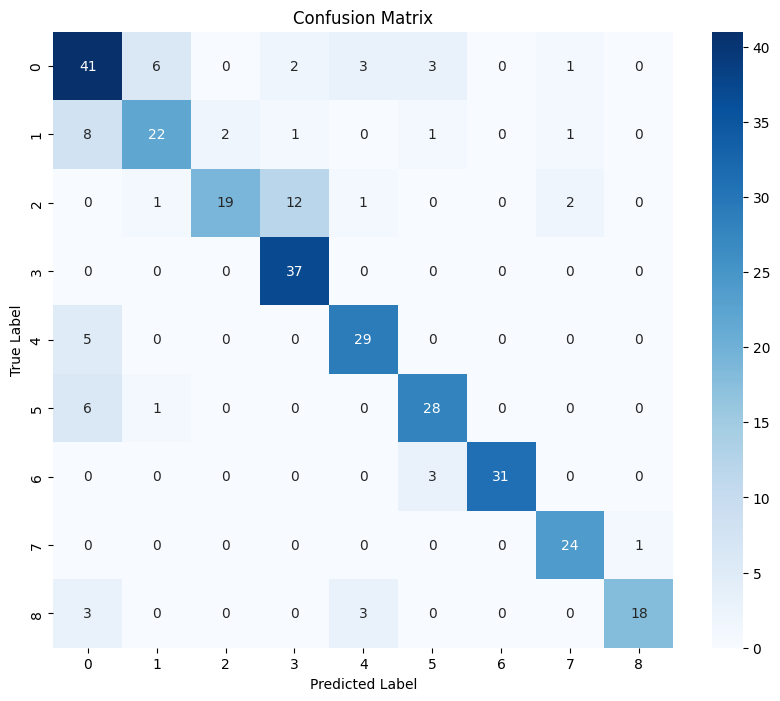

Accuracy:  0.7904761904761904
Precision:  0.8233882426864884
Recall:  0.7975863678804855
              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69        56
         1.0       0.73      0.63      0.68        35
         2.0       0.90      0.54      0.68        35
         3.0       0.71      1.00      0.83        37
         4.0       0.81      0.85      0.83        34
         5.0       0.80      0.80      0.80        35
         6.0       1.00      0.91      0.95        34
         7.0       0.86      0.96      0.91        25
         8.0       0.95      0.75      0.84        24

    accuracy                           0.79       315
   macro avg       0.82      0.80      0.80       315
weighted avg       0.81      0.79      0.79       315



In [50]:
# Plot confusion matrix and get other evaluation metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns

classes = np.arange(0, 9)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')


cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print(classification_report(y_test, y_pred_classes))

In [9]:
# PCA decomposition

n_samples, n_freq, n_time, n_channels = X_final.shape
X = X_final.reshape(-1, n_channels)

# Apply PCA to reduce channels
pca = PCA(n_components=32)
X_reduced = pca.fit_transform(X)

# Reshape back to (num_samples, freq_bins, time, n_components)
reduced_data = X_reduced.reshape(n_samples, n_freq, n_time, 32)
print("Reduced shape:", reduced_data.shape)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(reduced_data, y_total, test_size=0.2, random_state=42)
print(X_pca_train.shape)
print(X_pca_test.shape)

Reduced shape: (1575, 49, 4, 32)
(1260, 49, 4, 32)
(315, 49, 4, 32)


In [10]:
# PCA decomposition

n_samples, n_freq, n_time, n_channels = X_final.shape

channel_scores = np.mean(np.abs(pca.components_), axis=0)

# Rank channels by score
sorted_channels = np.argsort(channel_scores)[::-1]

print("Most influential channels:")
# Print the top 5 influential channels
for i in sorted_channels[:5]:
    print(f"Channel {i} - Score: {channel_scores[i]:.4f}")

print(f"Shape of pca.components_: {pca.components_.shape}")

print("\nOriginal Channels:")
top_scores = []
for i in sorted_channels[:10]:
    # Map the index relative to the kept channels back to the original index (0-255)
    original_channel_index = channels_to_keep[i]
    print(f"Original Channel {original_channel_index} (Index in reduced set: {i}) - Score: {channel_scores[i]:.4f}")
    top_scores.append(channel_scores[i])

Most influential channels:
Original Channel 61 - Score: 0.1210
Original Channel 62 - Score: 0.1192
Original Channel 63 - Score: 0.1152
Original Channel 10 - Score: 0.1062
Original Channel 77 - Score: 0.1006
Shape of pca.components_: (32, 245)

Most influential *Original* Channels (if some were removed):
Original Channel 69 (Index in reduced set: 61) - Score: 0.1210
Original Channel 70 (Index in reduced set: 62) - Score: 0.1192
Original Channel 71 (Index in reduced set: 63) - Score: 0.1152
Original Channel 15 (Index in reduced set: 10) - Score: 0.1062
Original Channel 86 (Index in reduced set: 77) - Score: 0.1006
Original Channel 79 (Index in reduced set: 71) - Score: 0.1002
Original Channel 87 (Index in reduced set: 78) - Score: 0.0999
Original Channel 13 (Index in reduced set: 8) - Score: 0.0968
Original Channel 72 (Index in reduced set: 64) - Score: 0.0962
Original Channel 80 (Index in reduced set: 72) - Score: 0.0912


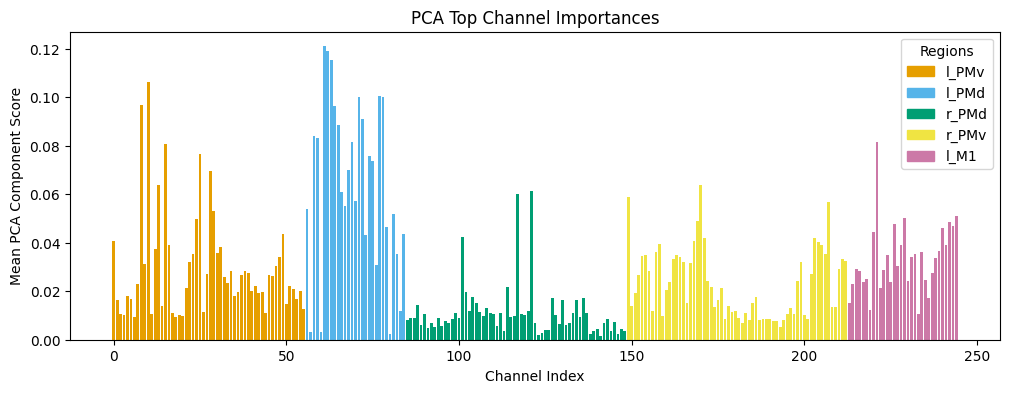

In [14]:
# Plot all PCA channel scores

orig_channels = [69, 70, 71, 15, 79, 86, 87, 13, 72, 80]
def get_region_for_channel(channel_idx):
    for region, (start, end) in regions.items():
        if start <= channel_idx <= end:
            return region
regions = {
    'l_PMv': (0, 55),
    'l_PMd': (56, 84),
    'r_PMd': (85, 148),
    'r_PMv': (149, 212),
    'l_M1': (213, 244)
}

region_colors = {
    'l_PMv': '#E69F00',  # orange
    'l_PMd': '#56B4E9',  # sky blue
    'r_PMd': '#009E73',  # green
    'r_PMv': '#F0E442',  # yellow
    'l_M1':  '#CC79A7',  # redish purple
}

channel_indices = np.arange(len(channel_scores))
colors = [region_colors[get_region_for_channel(i)] for i in channel_indices]

# plot scores
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4))
plt.bar(channel_indices, channel_scores, color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean PCA Component Score")
plt.title("PCA Top Channel Importances")
handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
plt.legend(handles, regions.keys(), title="Regions")
plt.savefig("pca_channels.pdf", format='pdf')

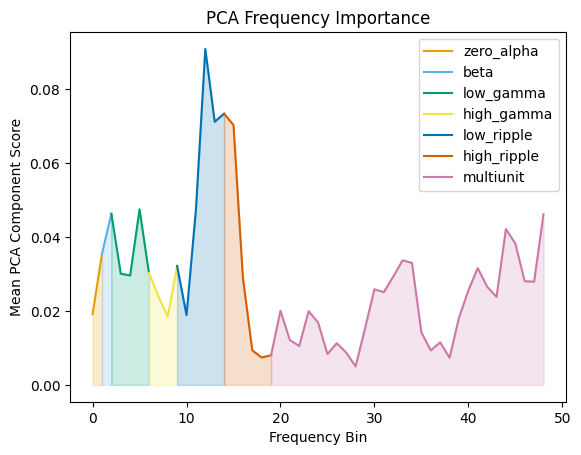

In [13]:
# Plot PCA freq importnace
n_freq = 49
loadings_per_freq = pca.components_.reshape(32, n_freq, -1)
mean_importance_per_freq = np.mean(np.abs(loadings_per_freq), axis=(0, 2))

bands = {
    'zero_alpha': (0, 1),
    'beta':  (1, 2),
    'low_gamma': (2, 6),
    'high_gamma': (6, 9),
    'low_ripple': (9, 14),
    'high_ripple': (14, 19),
    'multiunit': (19, 49)
}

color_ranges = {
    (0, 1): '#E69F00',  # orange
    (1, 2): '#56B4E9',  # sky blue
    (2, 6): '#009E73',  # green
    (6, 9): '#F0E442',  # yellow
    (9, 14): '#0072B2', # blue
    (14, 19): '#D55E00', # vermilion
    (19, 49): '#CC79A7' # redish purple
}

# Plot frequency importance
for band_name, (f_start, f_end) in bands.items():
    plot_freq_importance = mean_importance_per_freq[f_start:f_end + 1]
    x_values = range(f_start, f_start + len(plot_freq_importance))
    color = color_ranges[(f_start, f_end)]
    plt.plot(x_values, plot_freq_importance, color=color, label=band_name)
    plt.fill_between(x_values, plot_freq_importance, color=color, alpha=0.2)
plt.legend()
plt.xlabel('Frequency Bin')
plt.ylabel('Mean PCA Component Score')
plt.title('PCA Frequency Importance')
plt.savefig("pca_freqs.pdf", format="pdf")
plt.show()

In [ ]:
# Preparing grid search for PCA data
from keras import backend as K
from itertools import product

# Define parameter options
param_options = {
    'input_shape': [(49, 4, 32)],
    'layer1': [16, 32],
    'kernel1': [(3, 3), (5, 3)],
    'layer2': [32, 64],
    'kernel2': [(5,3), (7,3)],
    'pool_size': [(2,2)],
    'lstm_size': [32, 64],
    'cnn_dense': [32, 64],
    'denselayer': [64, 128],
    'cnn_dropout': [0.3, 0.4],
    'lstm_dropout': [0.3, 0.4],
    'end_dropout': [0.4, 0.5],
    'batch_size': [128],
    'epochs': [100],
}

# Generate all combinations
all_params = [dict(zip(param_options.keys(), values))
             for values in product(*param_options.values())]

# Code to start gridsearch from place where colab GPU finishes
last_completed_parallel = {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3),
                           'layer2': 64, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 64,
                           'cnn_dense': 64, 'denselayer': 64, 'cnn_dropout': 0.4, 'lstm_dropout': 0.4,
                           'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

start_index = next(i for i, param in enumerate(all_params) if param == last_completed_parallel) + 15


best_score = 0
best_params = None

results = []

for params in all_params[start_index:]:
#for params in all_params:
    print(f"\nTesting params: {params}")

    tf.keras.backend.clear_session()
    tf.config.run_functions_eagerly(True)

    # Build model
    model = build_parallel_model(
        input_shape = params['input_shape'],
        layer1 = params['layer1'],
        kernel1 = params['kernel1'],
        layer2 = params['layer2'],
        kernel2 = params['kernel2'],
        pool_size = params['pool_size'],
        lstm_size= params['lstm_size'],
        cnn_dense = params['cnn_dense'],
        denselayer = params['denselayer'],
        cnn_dropout = params['cnn_dropout'],
        lstm_dropout = params['lstm_dropout'],
        end_dropout = params['end_dropout'],
    )

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

    # Compile with current learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train with early stopping
    history = model.fit(
        X_pca_train, y_pca_train,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Get best validation accuracy
    val_acc = max(history.history['val_accuracy'])

    results.append({
        **params,
        'val_acc': val_acc
    })

    if val_acc > best_score:
        best_score = val_acc
        best_params = params
        print(f"New best val_acc: {best_score:.4f}")

print("\nFinal best parameters:")
print(best_params)
print(f"Best validation accuracy: {best_score:.4f}")




Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'pool_size': (2, 2), 'lstm_size': 32, 'cnn_dense': 32, 'denselayer': 64, 'cnn_dropout': 0.4, 'lstm_dropout': 0.3, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


New best val_acc: 0.6667

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'pool_size': (2, 2), 'lstm_size': 32, 'cnn_dense': 32, 'denselayer': 64, 'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}
New best val_acc: 0.6944

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'pool_size': (2, 2), 'lstm_size': 32, 'cnn_dense': 32, 'denselayer': 64, 'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'pool_size': (2, 2), 'lstm_size': 32, 'cnn_dense': 32, 'denselayer': 128, 'cnn_dropout': 0.3, 'lstm_dropout': 0.3, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3

KeyboardInterrupt: 

In [ ]:
# Sort all results by validation accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['val_acc'], reverse=True)

# Print top results
print("\nTop 5 validation accuracies and corresponding parameters:")
for i, res in enumerate(sorted_results[:2], 1):
    print(f"\nRank {i}")
    print(f"Validation Accuracy: {res['val_acc']:.4f}")
    print("Parameters:")
    for k, v in res.items():
        if k != 'val_acc':
            print(f"  {k}: {v}")



Top 5 validation accuracies and corresponding parameters:

Rank 1
Validation Accuracy: 0.7659
Parameters:
  input_shape: (49, 4, 32)
  layer1: 16
  kernel1: (3, 3)
  layer2: 32
  kernel2: (7, 3)
  pool_size: (2, 2)
  lstm_size: 64
  cnn_dense: 64
  denselayer: 128
  cnn_dropout: 0.3
  lstm_dropout: 0.3
  end_dropout: 0.4
  batch_size: 128
  epochs: 100

Rank 2
Validation Accuracy: 0.7579
Parameters:
  input_shape: (49, 4, 32)
  layer1: 16
  kernel1: (3, 3)
  layer2: 32
  kernel2: (7, 3)
  pool_size: (2, 2)
  lstm_size: 32
  cnn_dense: 64
  denselayer: 64
  cnn_dropout: 0.4
  lstm_dropout: 0.4
  end_dropout: 0.5
  batch_size: 128
  epochs: 100


In [ ]:
# Preparing grid search
from keras import backend as K
from itertools import product

# Define parameter options
param_options = {
    'dim_size': [1],
    'layer1': [16, 32],
    'kernel1': [(3, 3), (5,3)],
    'layer2': [32, 64],
    'kernel2': [(5,3), (5,3)],
    'pool_size': [(2,2)],
    'lstm_size': [32, 64, 128],
    'denselayer': [64, 128],
    'cnn_dropout': [0.3, 0.4],
    'lstm_dropout': [0.3, 0.4],
    'end_dropout': [0.4, 0.5],
    'batch_size': [128],
    'epochs': [100],
}

# Generate all combinations
all_params = [dict(zip(param_options.keys(), values))
             for values in product(*param_options.values())]

# Code to start gridsearch from place where colab GPU finishes
'''last_completed_parallel = {'dim_size': 1, 'layer1': 16, 'kernel1': (5, 3),
                                          'layer2': 64, 'kernel2': (7, 3), 'cnn_dense': 64,
                                           'denselayer': 128, 'pool_size': (2, 2), 'lstm_size': 128,
                                           'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.5,
                                           'batch_size': 128, 'epochs': 100}
start_index = next(i for i, param in enumerate(all_params) if param == last_completed) + 1'''

# For full model
'''last_completed_full = {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 64,
                       'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 64,
                       'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}
start_index = next(i for i, param in enumerate(all_params) if param == last_completed_full) + 1'''

best_score = 0
best_params = None

results = []

for params in all_params[start_index:]:
#for params in all_params:
    print(f"\nTesting params: {params}")

    tf.keras.backend.clear_session()
    tf.config.run_functions_eagerly(True)

    # Build model
    model = build_full_model(
        dim_size=params['dim_size'],
        layer1=params['layer1'],
        kernel1=params['kernel1'],
        layer2=params['layer2'],
        kernel2=params['kernel2'],
        pool_size=params['pool_size'],
        lstm_size=params['lstm_size'],
        denselayer=params['denselayer'],
        cnn_dropout=params['cnn_dropout'],
        lstm_dropout=params['lstm_dropout'],
        end_dropout=params['end_dropout'],
        num_classes=9
    )

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

    # Compile with current learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train with early stopping
    history = model.fit(
        X_train, y_train,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Get best validation accuracy
    val_acc = max(history.history['val_accuracy'])

    results.append({
        **params,
        'val_acc': val_acc
    })

    if val_acc > best_score:
        best_score = val_acc
        best_params = params
        print(f"New best val_acc: {best_score:.4f}")

print("\nFinal best parameters:")
print(best_params)
print(f"Best validation accuracy: {best_score:.4f}")




Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.3, 'lstm_dropout': 0.4, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


New best val_acc: 0.8056

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.3, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.3, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}
New best val_acc: 0.8095

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0

In [ ]:
# Test model with best parameters

opt_model = build_cnn_lstm(input_shape=(49, 4, 32), layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(7,3), pool_size=(2,2),
                                 lstm_size=64, denselayer=128, cnn_dropout=0.3,
                                 lstm_dropout=0.3, end_dropout=0.4, num_classes=9)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

opt_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = opt_model.fit(X_pca_train, y_pca_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1105 - loss: 2.2127 - val_accuracy: 0.1825 - val_loss: 2.1743 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1946 - loss: 2.1743 - val_accuracy: 0.1825 - val_loss: 2.1587 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2046 - loss: 2.1685 - val_accuracy: 0.1825 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2011 - loss: 2.1377 - val_accuracy: 0.1825 - val_loss: 2.1121 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2195 - loss: 2.0967 - val_accuracy: 0.2579 - val_loss: 2.0364 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2999 - loss: 1.9797 - val_accuracy: 0.2659 - val_loss: 1.9186 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3076 - loss: 1.8728 - val_accuracy: 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


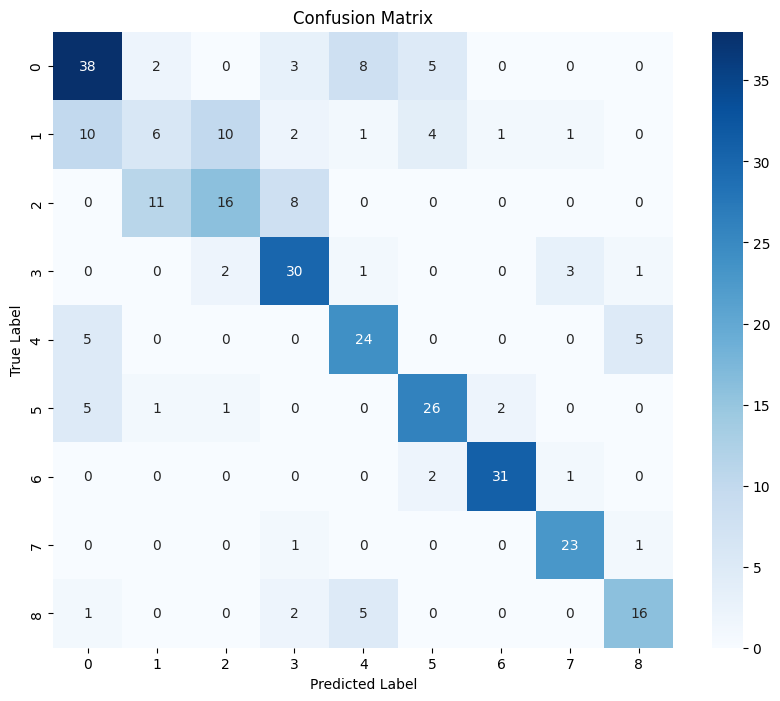

Accuracy:  0.6666666666666666
Precision:  0.6549887352106631
Recall:  0.6739027262556676
              precision    recall  f1-score   support

         0.0       0.64      0.68      0.66        56
         1.0       0.30      0.17      0.22        35
         2.0       0.55      0.46      0.50        35
         3.0       0.65      0.81      0.72        37
         4.0       0.62      0.71      0.66        34
         5.0       0.70      0.74      0.72        35
         6.0       0.91      0.91      0.91        34
         7.0       0.82      0.92      0.87        25
         8.0       0.70      0.67      0.68        24

    accuracy                           0.67       315
   macro avg       0.65      0.67      0.66       315
weighted avg       0.65      0.67      0.65       315



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns

classes = np.arange(0, 9)

y_pred = opt_model.predict(X_pca_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_pca_test, y_pred_classes)
precision = precision_score(y_pca_test, y_pred_classes, average='macro')
recall = recall_score(y_pca_test, y_pred_classes, average='macro')


cm = confusion_matrix(y_pca_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print(classification_report(y_pca_test, y_pred_classes))

# Grid Search Results


## Without cleaning


#### CNN only
opt_model = build_cnn_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3),
                             denselayer=128, pool_size=(2,2),
                             layer_dropout=0.2, end_dropout=0.5, num_classes=9)

gets test accuracy of 81.2%

#### CNN into LSTM
model = build_full_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3),
                         pool_size=(2,2), lstm_size=64, denselayer=128, cnn_dropout=0.2,
                         lstm_dropout=0.2, end_dropout=0.5, num_classes=9)

78%

#### Parallel CNN and LSTM

model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32, kernel2=(7,3),
                             pool_size=(2,2), lstm_size=64, cnn_dense=64, denselayer=128, cnn_dropout=0.3,
                             lstm_dropout=0.3, end_dropout=0.5, num_classes=9)

75.5%

## With Cleaning

### CNN Only

opt_model = build_cnn_model(dim_size=1, layer1=32, kernel1=(7,3), layer2=64,
                                 kernel2=(7,3), denselayer=128, pool_size=(2,2),
                                 layer_dropout = 0.3, end_dropout=0.5, num_classes=9)

75.2%

#### CNN Into LSTM

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=32, cnn_dropout=0.4, lstm_dropout=0.4,
                                 end_dropout=0.4, num_classes=9)

83.2%

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=128, cnn_dropout=0.3, lstm_dropout=0.4,
                                 end_dropout=0.5, num_classes=9)

81.6%

### Parallel Model
opt_model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32,
                                 kernel2=(5,3), cnn_dense=128, denselayer=64, pool_size=(2,2),
                                 lstm_size=64, cnn_dropout=0.3, lstm_dropout = 0.4, end_dropout=0.5, num_classes=9)

81.6%

opt_model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32,
                                 kernel2=(7,3), cnn_dense=64, denselayer=128, pool_size=(2,2),
                                 lstm_size=64, cnn_dropout=0.4, lstm_dropout = 0.3, end_dropout=0.5, num_classes=9)

82.2%

## PCA

#### CNN Only

opt_model = build_cnn(input_shape=(49, 4, 32), layer1=16, kernel1=(3,3), layer2=64,
                                 kernel2=(7,3), denselayer=64, pool_size=(2,2),
                                 layer_dropout=0.4,
                                 end_dropout=0.4, num_classes=9)

74.6%

#### CNN into LSTM

opt_model = build_cnn_lstm(input_shape=(49, 4, 32), layer1=16, kernel1=(3,3), layer2=64,
                                 kernel2=(7,3), pool_size=(2,2),
                                 lstm_size=32, denselayer=64, cnn_dropout=0.3,
                                 lstm_dropout=0.3, end_dropout=0.4, num_classes=9)
                  
71.4%

### Parallel Model

opt_model = build_cnn_lstm(input_shape=(49, 4, 32), layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(7,3), pool_size=(2,2),
                                 lstm_size=64, denselayer=128, cnn_dropout=0.3,
                                 lstm_dropout=0.3, end_dropout=0.4, num_classes=9)

71.7%

In [51]:
# save model
save_path = '/content/drive/MyDrive/parallel_test.keras' # Specify the full path within your Google Drive
model.save(save_path)
print(f"Model saved successfully to {save_path}")

Model saved successfully to /content/drive/MyDrive/parallel_test.keras


In [ ]:
sorted_results = sorted(results, key=lambda x: x['val_acc'], reverse=True)

# Print the sorted results
for result in sorted_results:
    print(result)

{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 128, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.2, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.841269850730896}
{'dim_size': 1, 'layer1': 32, 'kernel1': (7, 3), 'layer2': 64, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.2, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.829365074634552}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'denselayer': 128, 'pool_size': (3, 3), 'layer_dropout': 0.2, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.8134920597076416}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.1, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.7936508059501648}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 128, 'kernel2': (5, 3), 'd